# Logistic Regression

로지스틱회귀는 이진분류문제를 풀기위한 모형이며 종속변수 Y는 범주형 변수로 2가지 값 0또는 1만을 가질 수 있습니다. 파라미터를 사용하여 종속변수 y값을 설명한다는 점에서 선형회귀와 비슷하지만 y가 범주형변수라는 점과 분류문제에 사용되는 모델이라는 차이점이 있습니다.

# 가정
로지스틱회귀의 기본 가정은 다음과 같습니다.

`-` 각각의 데이터요소(샘플)는 여러개의 독립변수와 0또는1만 가질수 있는 종속변수로 이루어져 있습니다. <br>
`-` 임의의 m개의 독립변수와 이진 종속변수를 가지는 i번째 샘플을 나타나면 다음과 같습니다.$x_{m,i}$는 임의의 i번째 관측치의 m번째 변수를 의미합니다<br>

$$(x_{1,i},x_{2,i},\dots,x_{m,i}),Y_{i} $$

`-` $x_{1,i},x_{2,i},\dots,x_{m,i}$가 주어질 때, 종속변수 $Y_{i}$는 베르누이 분포를 따르는 확률변수입니다.<br>

\begin{aligned}
& Y_i|x_{1,i},x_{2,i},\dots,x_{m,i} \sim \text{Bernouli}(p_{i}) \nonumber \\
& \text{where},p_{i} = P(Y|X=1)
\end{aligned}

`-` 확률변수$Y_{i}$가 따르는 확률함수를 구체적으로 표현한 식입니다.<br>
$$Pr\,(Y_{i} = y|x_{1,i},x_{2,i},\dots,x_{m,i}\,) =
\begin{cases} 
p_i   & \text{if }y=1, \\
1-p_i & \text{if }y=0
\end{cases} = p_i^y(1-p_i)^{1-y}$$
<br>

`-` 기댓값은 실험 또는 시행을 무한히 반복했을때 확률변수가 취하는 값의 평균으로 기대되는(expected) 값(value)입니다. 베르누이분포를 따르는 확률변수 $Y_{i}$의 기댓값을 구하면 다음과 같습니다.<br>

$$E\,[Y|x_{1,i},x_{2,i},\dots,x_{m,i}]\, = \sum_{i=0}^{i=1}p_iy = 1 \times p_{i} + 0 \times (1-p_{i}) = p_{i}$$


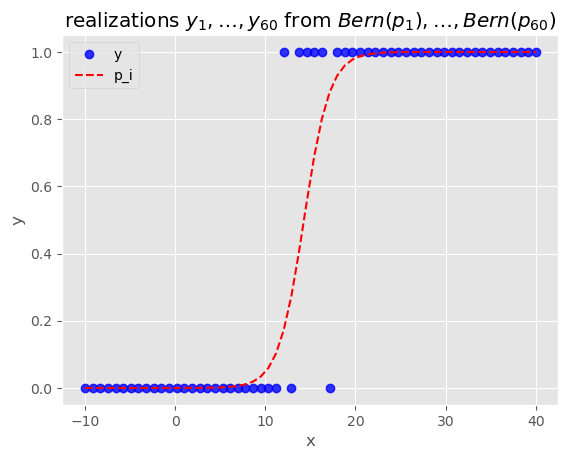

In [75]:
#| echo: false
import torch
import matplotlib.pyplot as plt
plt.style.use('ggplot')


torch.manual_seed(2022)
n=60

#1 모수 W가정
W = torch.tensor(
    [[-10],
    [0.7]]).float()

#2 각각의 관측치(데이터요소)에서의 모수 p_i시각화(시그모이드 함수 시각화)
_x = torch.linspace(-10,40,n).reshape(-1,1)
_one = torch.ones((n,1))
X = torch.concat((_one,_x),axis=1)
sig = lambda z:1/(1+torch.exp(-z))
p_i = sig(X@W)
y = torch.bernoulli(p_i)
plt.plot(X[:,1],y,"bo",alpha=0.8)
plt.plot(X[:,1],p_i,"r--")
plt.xlabel("x")
plt.ylabel("y")
plt.title("realizations $y_1,\dots,y_{60}$ from $Bern(p_1),\dots,Bern(p_{60})$")
plt.legend(["y","p_i"])

## 기댓값에 대한 고찰
기댓값은 실험 또는 시행을 무한히 반복했을때 확률변수가 취하는 값의 평균으로(또는 샘플링된 값의 평균) 기대되는 값입니다. 확률변수가 베르누이 분포를 따르는 경우 확률변수에 대한 기댓값($E\,[y|x_{1,i},x_{2,i}\.,\dots,x_{m,i}]$)과 모수$(p_i)$가 같은 값을 가집니다. 그러므로,만약에 주어진 샘플데이터로부터 베르누이분포의 모수를 적절히 추정할 수 있다면 주어진 조건하에서 실험 또는 시행을 무한히 반복할 경우 확률변수가 1인사건과 0인사건중 어떤 사건이 더 많이 발생할지 알 수 있고 이를 바탕으로 종속변수 Y의 값을 결정하는 것은 타당합니다.<br>
`-` e.g.<br>

- $E\,[y]\, = \hat{p_i}<0.5$ => 무한히 실행했을때 0인 경우가 더 많을 것임 => 관측치를 0으로 예측
<br>
- $E\,[y]\, = \hat{p_i}\geq0.5$=>무한히 실행했을때 1인 경우가 더 많을 것임 => 관측치를 1로 예측

# 로지스틱회귀 수식 유도

## concept

선형회귀에서 추정하고자하는 변수$y$는 $x_0,x_1,...,x_m$과 $w_0,w_1,...,w_m$과의 linear combination이였습니다.위에서 언급했듯이 특정샘플에 대한 모수를 적절하게 추정할 수 있다면 관측치가 어떤 클래스에 속할지 합리적으로 알 수 있으므로,로지스틱회귀에서도 선형회귀에서의 아이디어를 핵심아이디어를 가지고와서 추정하고자 하는 모수$p_i$를  $x_0,x_1,...,x_m$과 $w_0,w_1,...,w_m$의 linear combination로 표현하고자 합니다.<br>

`선형회귀의 아이디어(linear combination)` + `모수에 대한 표현`이라는 조건을 만족하기 위해서 최종적인 식은 다음과 조건을 만족해야 것입니다.<br>
`-` $(x_0,x_1,...,x_m)\,,(w_0,w_1,..,w_m)$의 linear combination 식에 있어야 함.<br>
`-` linearcombination = 모수(추정하고자하는값)여야 함.

why linear combination?

## 본격적인 유도

### 모수를 로지스틱함수로 바꾸기

1. $(x_0,x_1,...,x_m)\,,(w_0,w_1,..,w_m)$의 linear combination이 식에 존재해야 합니다. 그러므로 선형방정식을 하나 만듭니다.<br>
\begin{align}
f(i) = x_{1,i}w_0 + x_{2,i}w_1 + x_2w_2 + ... + x_{m,i}w_m = X_iW \nonumber \\
where,X_i = \,[x_{1,i},x_{2,i},\dots,x_{m,i}]\, ,W = \,[w_0,w_1,\dots,w_m]^\text{T} \nonumber \\
\end{align}
2. 좌변은 예측하고자 하는 값인 모수여야 합니다. 좌변을 바꿔봅니다.
$$p_i = WX_i$$
3. 좌변의 베르누이 분포의 모수 $p_i$는 확률변수 $y = 1$인 사건이 일어날 확률입니다. 그러므로 $[0,1]$이라는 범위를 가지는 반면 우변의 값$WX_i$은 $\,[-\infty,\infty]\,$에 범위를 가집니다.  여기서 Odss Ratio를 써서 모수 $p_i$를 포함하며 더 넓은 range를 갖도록 좌변을 수정합니다.
$$\text{Odds Ratio} = \frac{p_i}{1-p_i} = WX_i$$
4. 좌변을 Odds Ratio로 수정했지만 여전히 좌변의 범위는$\,[0,\infty]\,$으로 우변에 비해 좁습니다. 따라서 Odds Ratio에 로짓변환을 취하여 좌변의 범위를 $\,[-\infty,\infty]$로 넓혀줍니다.
$$\text{logit}(p) = \text{ln}\frac{p_i}{1-p_i} = WX_i$$

위 식을 해석하기 위해 $X$의 첫번째 요소인 $x_1$에 대응하는 회귀계수 $w_1$이 학습결과 3으로 정해졌다고 가정해봅시다.만약 $x_1$의 값이 1증가한다면 로그오즈비가 3증가합니다.<br>

5. 이제 양변의 범위는 맞춰졌으므로 추정하고자 하는 변수 $p_i$가 좌변에 오도록 정리해봅시다.
$$p_i = \frac{1}{\,(1 + e^{-WX_i})\, }$$
(전개)<br>
$\frac{p_i}{1-p_i} = e^{WX_i}$<br>
$\Longleftrightarrow p_i = \,(1-p_i)\,e^{WX_i}$<br>
$\Longleftrightarrow p_i = \,e^{WX_i}-p_ie^{WX_i}$<br>
$\Longleftrightarrow p_i + p_ie^{WX_i} = \,e^{WX_i}$<br>
$\Longleftrightarrow p_i\,(1 + e^{WX_i})\, = \,e^{WX_i}$<br>
$\Longleftrightarrow p_i = \frac{\,e^{WX_i}}{\,(1 + e^{WX_i})\, }$<br>
$\Longleftrightarrow p_i = \frac{1}{\,(1 + e^{-WX_i})\, }$<br>

최종적으로, 앞서 목적이었던 X와 W의 선형조합이 수식내부에 존재하도록 새롭게 표현한 모수는 다음과 같습니다.
$$p_i(y) = Pr\,(y = 1|X_i;W)\, = \frac{1}{\,1 + e^{-WX_i}\,}$$

### 베르누이 분포의 pmf 정리

베르누이분포의 모수 $p_i$가 새롭게 표현되었으므로 확률질량함수도 새롭게 표현할 수 있습니다.
마지막 수식은 베르누이 분포의 확률질량함수가 모수$W$에 관한 식으로 바뀌었음을 표현합니다.


\begin{align}
Bern(y;p_i) = Pr\,(Y_{i} = y|x_{1,i},x_{2,i},\dots,x_{m,i};p_i) &= 
\begin{cases} 
p_i & \text{if}\,y=1 \\
1-p_i & \text{if}\,y=0 
\end{cases} \\
&= p_i^{y}(1-p_i)^{1-y} \\ 
&= \frac{e^{yWX_i}}{1+e^{WX_i}}
\end{align}
<br>



# MLE 

베르누이 분포의 모수 $W$만 적절하게 추정할 수  있다면 임의의 데이터에 대해서 독립변수 $X_i = (x_{0,i},x_{1,i},\dots,x_{m,i})$가 들어왔을때 $p_i = Pr(Y=1|X_i;w)$를 구하고 샘플이 속하는 적절한 클래스(0 또는 1)을 예측할 수 있습니다. 베르누이 분포의 모수는 어떻게 추정할 수 있을까요?<br>

주어진 상황은 다음과 같습니다.<br>

1. 주어진 데이터
\begin{aligned}
&\text{Given}\, ,D={(X_i,y)}_{i=1}^{i=n} \\
& \text{where}\, ,X_i = ({x_{0,i},x_{1,i},\dots,x_{m,i})}
\end{aligned}
<br>
2. 로지스틱 회귀의 가정
\begin{aligned}
&\text{Suppose that data(or sample) } y_1,y_2,\dots,y_n \text{ are realization of a random variables } \\
&Y_1,Y_2,Y_3,\dots,Y_n \\
&\text{where,}\, Y_1 \sim Bern(Y|X_1;W),Y_2 \sim Bern(Y|X_2;W),\dots,Y_N \sim Bern(Y|X_n;W)\\
\end{aligned}
<br>

MLE를 통해 모수를 추정합니다.(참고:[MLE](https://hoyeon1234.github.io/sin-hoyeon/posts/probabilty,statistics/MLE.html))<br>
가능도는 다음과 같습니다.<br>
$$L(W;y_1,y_2,\dots,y_n) = p_{Y_1,Y_2,\dots,Y_n}(y_1,y_2,\dots,y_n;W) = \underset{i=1}{\overset{i=n}{\large{\prod}}}\frac{e^{y_iWX_i}}{1+e^{WX_i}}$$
<br>

우리가 구하고자 하는 추정값은 다음과 같습니다.<br>
\begin{aligned}
\hat{W}_{MLE} &= \underset{W}{\text{argmax}}\,\underset{i=1}{\overset{i=n}{\large{\prod}}}\frac{e^{y_iWX_i}}{1+e^{WX_i}} \\
&= \underset{W}{\text{argmin}}-\overset{n}{\underset{i=1}{\large{\sum}}}y_iWX_i + \overset{n}{\underset{i=1}{\large{\sum}}}ln(1+e^{WX_i})
\end{aligned}

목적함수가 최솟값을 가지려면 $\large{\frac{\partial J}{\partial w_0}=\frac{\partial J}{\partial w_1}=\frac{\partial J}{\partial w_2}=\dots\ = \frac{\partial J}{\partial w_m}} = 0$
<br>
즉,$\nabla_wJ(W) = [\large{\frac{\partial J}{\partial w_0},\frac{\partial J}{\partial w_1},\frac{\partial J}{\partial w_2}=\dots\,\frac{\partial J}{\partial w_m}}]^\text{T} = \overrightarrow{\bf{0}}$ 이어야 합니다. 목적함수를 임의의 $w_k$편미분하여 0이 되는 방정식은 다음과 같습니다<br>

\begin{aligned}
\frac{\partial J}{\partial w_k} = -\overset{n}{\underset{i=1}{\large{\sum}}}y_ix_{k,i} + \sum_{i=1}^{n}\frac{x_{k,i}e^{WX_i}}{1+e^{WX_i}} = 0
\end{aligned}
<br>

위와 같이 m개의 변수에 대해서 미분하면 m개의 방정식이 존재합니다. 그러나 정리하여 풀어낼 수 없는형태이므로 닫힌형태(closed-form)로 해가 존재하지 않습니다.

# Gradient descent

위에서 해석적으로 logstic regression의 해를 구할 수 없기때문에 다른 방법들을 써야합니다. 여기서는 경사하강법으로 해를 구합니다. 경사하강법을 사용하기 위해서 NLL을 베르누이분포의 2번식을 활용하여 전개하면 다음과 같습니다. 이번에는 베르누이 분포의 모수를 $p_i$로 놓고 진행했습니다.<br>
$$NLL = -\sum_{i=1}^{n}y_i\text{ln}\,p_i(1-y_i)\text{ln}\,(1-p_i)$$
<br>

우리의 목적은 다음과 같습니다.이번에는 모수가 $p_i$인 베르누이 분포였으므로 추정량도$\hat{p_i}$입니다.<br>

$$\hat{p_i} = \underset{p_i}{\text{argmin}}-\sum_{i=1}^{n}y_i\text{ln}\,p_i(1-y_i)\text{ln}\,(1-p_i)$$

위식에 대해서 직접 계산은 해보지 않았지만, 해석적으로 해를 구할 수 없음을 알았습니다. 그러므로 경사하강법을 이용해서 해를 구합니다. 최솟값을 찾고자 하는 Loss function은 다음과 같이 쓸 수 있습니다.Binary Cross Entropy와 같은 수식입니다.<br>
$$L(\hat{y_i}) = -\sum_{i=1}^{n}y_i\text{ln}\,\hat{y_i}+(1-y_i)\text{ln}\,(1-\hat{y_i})$$

::: {.callout-note}
약간의 notation 변경이 있습니다.로지스틱회귀의 likelyhood를 최대화(또는 최소화)하여 나온 estimated value(추정치)는 $\hat{p_i}$ = $\hat{y_i}$입니다. 경사하강법은 NLL에서 모수 $p_i$에 대한 추정치$\hat{p_i}$를 계속해서 대입해보고 틀린지 파악하고 반복적으로 추정치를 업데이트 합니다. 그러므로, $p_i$ 대신 $\hat{p_i}$를 쓰는 것으로 보입니다.
:::

# 구현

로지스틱회귀의 적합을 pytorch를 사용하여 구현. Gradient Descent 활용

## setting


In [76]:
import torch
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#sig = lambda z:torch.exp(z)/(1+torch.exp(z))
sig = torch.nn.Sigmoid()

## data

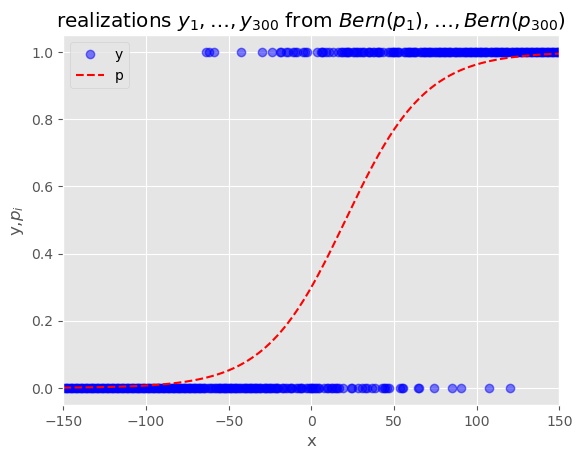

In [77]:
torch.manual_seed(2022)
n=400

#1 모수 W가정
W = torch.tensor(
    [[-0.8467],
    [0.041]]).float()

#2 각각의 관측치(데이터요소)에서의 모수 p_i시각화(시그모이드 함수 시각화)
_x = torch.linspace(-150,150,n).reshape(-1,1)
_one = torch.ones((n,1))
X = torch.concat((_one,_x),axis=1)
p_i = sig(X@W)
y = torch.bernoulli(p_i)
plt.xlim([-150,150])
plt.plot(X[:,1],y,"bo",alpha=0.5)
plt.plot(X[:,1],p_i,"r--")
plt.xlabel("x")
plt.ylabel("y,$p_i$")
plt.title("realizations $y_1,\dots,y_{300}$ from $Bern(p_1),\dots,Bern(p_{300})$")
plt.legend(["y","p"])

## Gradient Descent

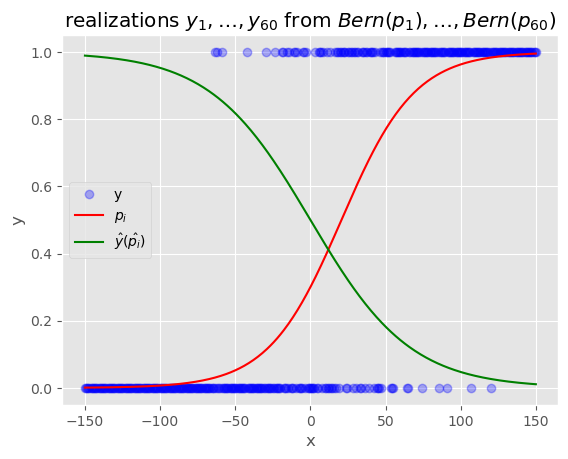

In [78]:
import torch
import matplotlib.pyplot as plt
plt.style.use('ggplot')


torch.manual_seed(2022)
n=400

#2 임의의 W에 대한 estimated value(추정치) What 초기화
What = torch.tensor(
    [[0.],
    [-0.03]],requires_grad=True)

_x = torch.linspace(-150,150,n).reshape(-1,1)
_one = torch.ones((n,1))
X = torch.concat((_one,_x),axis=1)
yhat = sig(X@What)

plt.plot(X[:,1].data,y,"bo",alpha=0.3)
plt.plot(X[:,1].data,p_i,"r")
plt.plot(X[:,1].data,yhat.data,"g")
plt.xlabel("x")
plt.ylabel("y")
plt.title("realizations $y_1,\dots,y_{60}$ from $Bern(p_1),\dots,Bern(p_{60})$")
plt.legend(["y","$p_i$","$\hat{y}(\hat{p_i})$"])


In [79]:
loss_fn = torch.nn.BCELoss()
"""
def BCE_Loss(yhat,y):
    return torch.mean(y * torch.log(yhat) + (1-y) * torch.log(1-yhat))
"""

'\ndef BCE_Loss(yhat,y):\n    return torch.mean(y * torch.log(yhat) + (1-y) * torch.log(1-yhat))\n'

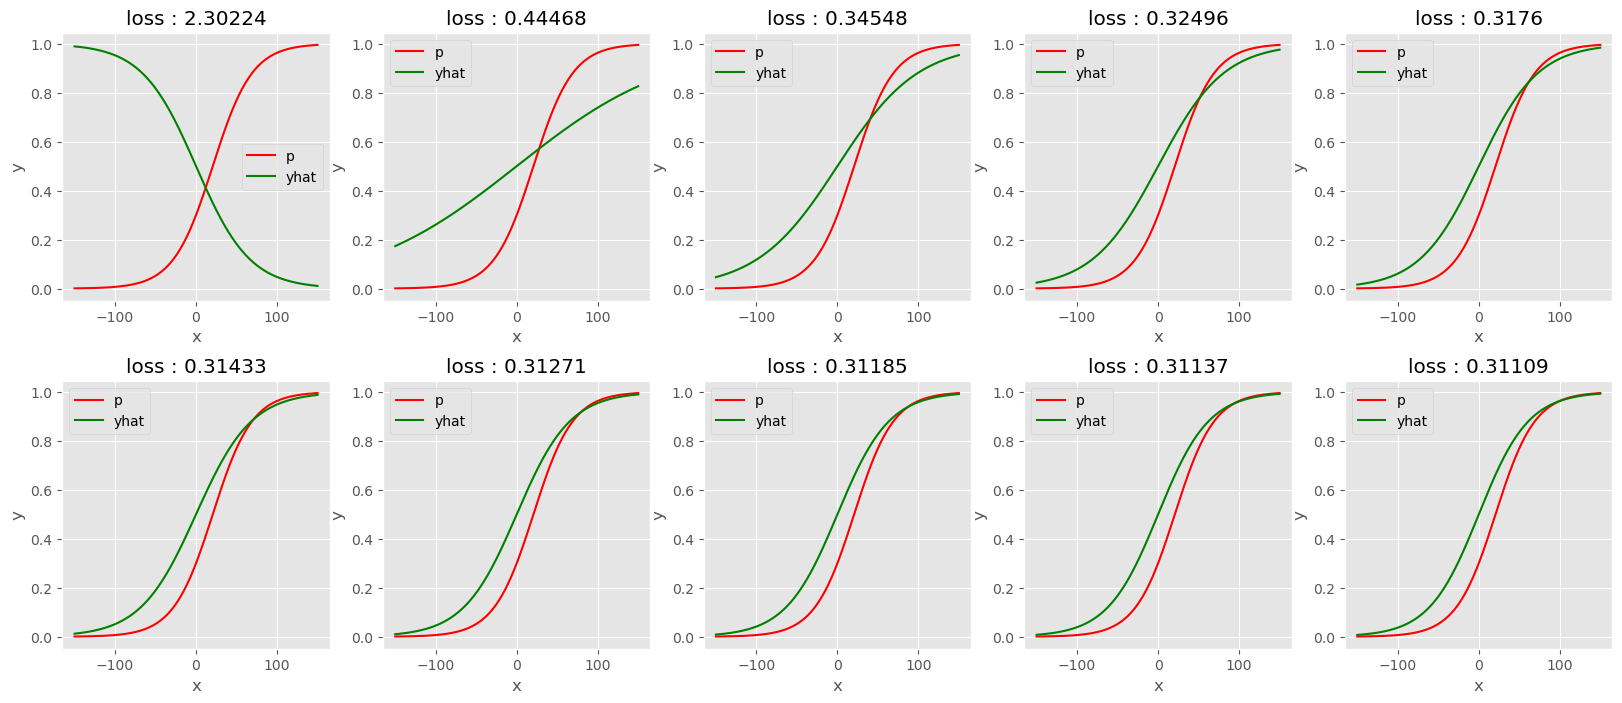

In [80]:
#custom sigmoid + torch.BCELoss 쓰면 오류 발생. 0과 1사이의 범위 아님
#torch.nn.Sigmoid + custom BCE Loss 써도 오류발생 => nan
plt.subplots(2,5,figsize=(20,8))
plt.subplots_adjust(hspace=0.3)
i=1

for epoch in range(200):
    #1 yhat 
    yhat = sig(X@What)
    #2 loss
    loss = loss_fn(yhat,y)
    if epoch % 20 == 0:
        plt.subplot(2,5,i)
        #plt.plot(X[:,1].data,y,"bo",alpha=0.3)
        plt.plot(X[:,1].data,p_i,"r")
        plt.plot(X[:,1].data,yhat.data,"g")
        plt.xlabel("x")
        plt.ylabel("y")
        #plt.title("realizations $y_1,\dots,y_{60}$ from $Bern(p_1),\dots,Bern(p_{60})$")
        plt.legend(["p","yhat"])
        title = "loss : {}".format(round(loss.tolist(),5))
        plt.title(title)
        i+=1
    #3 derivative
    loss.backward()
    #4 update & clean
    What.data = What.data - 0.00005 * What.grad
    What.grad = None

In [81]:
round(loss.tolist(),4)

0.3109

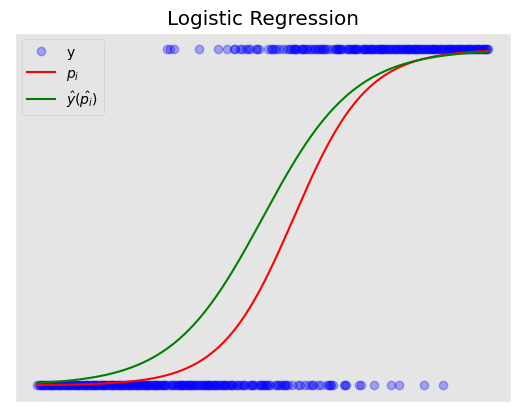

In [82]:
plt.plot(X[:,1].data,y,"bo",alpha=0.3)
plt.plot(X[:,1].data,p_i,"r")
plt.plot(X[:,1].data,yhat.data,"g")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Logistic Regression")
plt.legend(["y","$p_i$","$\hat{y}(\hat{p_i})$"])
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)

# 정리
- 로지스틱회귀는 종속변수 Y가 1과0을 가지는 이진분류 문제일때 사용하는 모형입니다.
- 각각의 관측치에서 y의 값은 $X_i$가 조건이며 모수가 $p_i = \frac{1}{1+e^{-WX_i}}$인 베르누이분포를 따르는 확률변수 $Y_i$의 realization이라고 가정합니다.
- 가정에 의해서 베르누이 분포의 모수$p_i$ 더 전개하여 또다른 모수 $W$만 적절하게 추정하면 임의의 데이터가 어떤 클래스에 속하는지 분류할 수 있습니다. 로지스틱회귀는 모수 $W$를 적절하게 추정치 $\hat{p_i}$을 출력하는 것을 목적으로 합니다.
- MLE로 모수 W를 추정할 수 있습니다. 이때 가능도(또는 로그가능도) 함수의 최댓값에 대한 닫힌형태의 해가 존재하지 않습니다.따라서 경사하강법을 통하여 해를 구합니다.
- 경사하강법의 Loss function은 NLL이며 이진분류의 CrossEntropy와 같습니다.

# Appendix

## 1.베르누이 분포 전개

\begin{aligned}
p_i^y(1-p_i)^{1-y} &= \ (\frac{1}{\,1 + e^{-WX_i}\,})^y\,\,(1-\frac{1}{\,1 + e^{-WX_i}\,})^{1-y} \\
&= (\frac{1}{1+e^{-WX_i}})^{y}(\frac{e^{-WX_i}}{1+e^{-WXi}})^{1-y} \\
&= (\frac{1}{1+e^{-WX_i}})^{y}(\frac{1}{1+e^{WXi}})^{1-y} \\
&= (\frac{1+e^{WX_i}}{1+e^{-WX_i}})^{y}(\frac{1}{1+e^{WX_i}}) \\
&= (\frac{e^{WX_i}+e^{2WX_i}}{1+e^{WX_i}})^{y}(\frac{1}{1+e^{WX_i}}) \\
&= (\frac{e^{WX_i}(1+e^{WX_i})}{1+e^{WX_i}})^{y}(\frac{1}{1+e^{WX_i}}) \\
&= e^{yWX_i}\frac{1}{1+e^{WX_i}} \\
&= \frac{e^{yWX_i}}{1+e^{WX_i}}
\end{aligned}


## 2.NLL전개(with parameter $W$)

\begin{aligned}
LL &= \text{ln}(\underset{i=1}{\overset{n}{\large{\prod}}}\,\frac{e^{y_iWX_i}}{1+e^{WX_i}}) \\
&=\overset{n}{\underset{i=1}{\large{\sum}}}(\text{ln}\frac{e^{y_iWX_i}}{1+e^{WX_i}}) \\
&= \overset{n}{\underset{i=1}{\large{\sum}}}\,[\text{ln}e^{y_iWX_i} - \text{ln}(1+e^{WX_i})]\, \\
&= \overset{n}{\underset{i=1}{\large{\sum}}}\,[y_iWX_i - \text{ln}(1+e^{WX_i})], \\
&= \overset{n}{\underset{i=1}{\large{\sum}}}y_iWX_i - \overset{n}{\underset{i=1}{\large{\sum}}}ln(1+e^{WX_i}) \\


NLL &= -\overset{n}{\underset{i=1}{\large{\sum}}}y_iWX_i + \overset{n}{\underset{i=1}{\large{\sum}}}ln(1+e^{WX_i}) \\

\end{aligned}

## 3.NLL전개(Cross Entropy 유도하기)
임의의 i번째 항에서의 확률변수 $Y_i$가 따르는 베르누이 분포는 다음과 같습니다.
<br>
\begin{aligned}
Bern(y|X_i;p_i) = (p_i)^y(1-p_i)^{y-1}
\end{aligned}
모수가 $p_i$인 각각의 베르누이 분포를 따르는 확률변수 $Y_1,Y_2\dots Y_n$으로부 n개의 realization(sample) $y_1,y_2\dots y_n$에 대한 NLL는 다음과 같습니다. 
<br>
\begin{aligned}
NLL &= -\text{ln}\prod_{i=1}^{n}p_i^{y_i}(1-p_i)^{1-y_i} \\
&= -\sum_{i=1}^{n}\text{ln}p_i^{y_i}(1-p_i)^{1-y_i} \\
&= -\sum_{i=1}^{n}\text{ln}p_i^{y_i} + \text{ln}(1-p_i)^{1-y_i} \\
&= -\sum_{i=1}^{n}y_i\text{ln}p_i + (1-y_i)\text{ln}(1-p_i)
\end{aligned}

참고링크<br>
1. [로지스틱 회귀 전개](https://www.analyticsvidhya.com/blog/2022/02/decoding-logistic-regression-using-mle/#h2_1)<br>
2. [위키피디아 - 로지스틱 회귀](https://en.wikipedia.org/wiki/Logistic_regression)<br>
3. [ratsgo's blog](https://ratsgo.github.io/machine%20learning/2017/07/02/logistic/)